<a href="https://colab.research.google.com/github/SatyaKuppam/QUBOs-and-Ising-models/blob/master/partitioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install dwave-ocean-sdk

     |████████████████████████████████| 81kB 2.6MB/s 
     |████████████████████████████████| 4.7MB 7.6MB/s 
     |████████████████████████████████| 204kB 20.8MB/s 
     |████████████████████████████████| 399kB 31.2MB/s 
     |████████████████████████████████| 92kB 11.8MB/s 
     |████████████████████████████████| 788kB 40.5MB/s 
     |████████████████████████████████| 92kB 9.2MB/s 
     |████████████████████████████████| 2.3MB 45.2MB/s 
     |████████████████████████████████| 92kB 11.6MB/s 
     |████████████████████████████████| 28.9MB 156kB/s 
     |████████████████████████████████| 1.3MB 45.3MB/s 
  Created wheel for pyqubo: filename=pyqubo-0.4.0-cp36-none-any.whl size=40712 sha256=d47ed29631463a4bb2cb89b4d24192ada4f6e4e56df3c3661d7d462a9a722de5
  Stored in directory: /root/.cache/pip/wheels/77/b7/47/b989889699f788f4fecdc534bfddbb16df9a9a51f4e431b04d
Successfully built pyqubo
  Found existing installation: protobuf 3.10.0
    Uninstalling protobuf-3.10.0:
      Successfully uninsta

In [0]:
!dwave setup

In [0]:
!dwave ping

Using endpoint: https://cloud.dwavesys.com/sapi/
Using solver: DW_2000Q_5
Submitted problem ID: 7998a08e-b7bb-4784-828c-75e7b834a48a

Wall clock time:
 * Solver definition fetch: 493.258 ms
 * Problem submit and results fetch: 1827.817 ms
 * Total: 2321.075 ms

QPU timing:
 * anneal_time_per_run = 20 us
 * post_processing_overhead_time = 430 us
 * qpu_access_overhead_time = 1965 us
 * qpu_access_time = 9692 us
 * qpu_anneal_time_per_sample = 20 us
 * qpu_delay_time_per_sample = 21 us
 * qpu_programming_time = 9377 us
 * qpu_readout_time_per_sample = 274 us
 * qpu_sampling_time = 315 us
 * readout_time_per_run = 274 us
 * run_time_chip = 315 us
 * total_post_processing_time = 430 us
 * total_real_time = 9692 us


In [0]:
import networkx as nx
import dwave_networkx as dnx
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
from dwave.cloud import Client
from dwave_qbsolv import QBSolv
from collections import defaultdict

import networkx as nx
import dwave_networkx as dnx
import neal

In [0]:
with Client.from_config() as client:
  print(client.get_solvers())

[StructuredSolver(id='DW_2000Q_5'), UnstructuredSolver(id='hybrid_v1')]


## 1. Number Partitioning

* This problem is know to be $NP$-complete.

* The ising model represenatation we consider for number partitioning[1] is $$H = A(\sum_{i=1}^{N}n_is_i)^2$$
* The corresponding QUBO representation is: $$Q = A(\sum_{i=1}^{N}n_i^2q_i-\sum_{i=1}^{N}\sum_{j=1}^{N}n_in_jq_i+2\sum_{1\leq i<j\leq N}n_in_jq_iq_j)$$

* Notice that in the QUBO representation we have disregarded the terms which are independent of $q_i$. Hence the minimum energy will be lower than 0.

* For simplicity of our experimentation we use $A=1$

Lets take the set of numbers of $[1,2,3,4]$ to be split into two sets.
The partition that gives us the least energy is $[1,4]$ and $[2,3]$.


In [0]:
def number_partition(numbers, sampler=None, num_repeats=1000):
  Q = defaultdict(int)

  for i in numbers:
    Q[(i,i)] += i ** 2

  for i in numbers:
    for j in numbers:
      Q[(i,i)] -= i * j

  for idx, number in enumerate(numbers):
    for jdx in range(idx+1,len(numbers)):
      Q[(number,numbers[jdx])] += 2 * number * numbers[jdx]

  return sampler.sample_qubo(Q, num_repeats=num_repeats)

In [55]:
response = number_partition(range(1,5), sampler=QBSolv())
print(response)
print("samples=" + str(list(response.samples())))
print("energies=" + str(list(response.data_vectors['energy'])))

   1  2  3  4 energy num_oc.
0  0  1  1  0  -25.0     472
1  1  0  0  1  -25.0     529
['BINARY', 2 rows, 1001 samples, 4 variables]
samples=[{1: 0, 2: 1, 3: 1, 4: 0}, {1: 1, 2: 0, 3: 0, 4: 1}]
energies=[-25.0, -25.0]


In the above example we could partition the sets into two whose sum of constituent elements in the same. Sometime its not possible to do so.
For example the set $[1,2,3,4,5]$. The partitions whose sum differ by atmost 1 are:

* [1,2,5] and [3,4]
* [1,2,4] and [3,5]
* [1,3,4] and [2,5]

In [44]:
response = number_partition(range(1,6), sampler=QBSolv())
print("samples=" + str(list(response.samples())))
print("energies=" + str(list(response.data_vectors['energy'])))

samples=[{1: 0, 2: 0, 3: 1, 4: 0, 5: 1}, {1: 0, 2: 1, 3: 0, 4: 0, 5: 1}, {1: 1, 2: 0, 3: 1, 4: 1, 5: 0}, {1: 0, 2: 0, 3: 1, 4: 1, 5: 0}, {1: 1, 2: 1, 3: 0, 4: 0, 5: 1}, {1: 1, 2: 1, 3: 0, 4: 1, 5: 0}]
energies=[-56.0, -56.0, -56.0, -56.0, -56.0, -56.0]


## 2. Graph Partitioning

* This problem is a known $NP$-hard problem.

* Given a graph with $N=|V|$ edges partition it into two sets of equal size (i.e $\frac{N}{2}$) such that, the number of edges between the two is minimized.

* From Lucas[1] the ising formulation for this energy function is: 
$$H_A = A(\sum_{i=1}^{N}s_i)^2$$ and $$H_B = B \sum_{(u,v)\in E} \frac{1-s_us_v}{2}$$ and $$H = H_A + H_B$$

* The corresponding QUBO formulation for this problem is: $$Q_A = A[(1-N)\sum_{i=1}^{N}q_i + 2 \sum_{1\leq i <j\leq N} q_iq_j]$$ and $$Q_B = B \sum_{(u,v)\in E}(q_u+q_v-2q_uq_v)$$ and $$Q = Q_A + Q_B$$


* From Lucas[1] we also get the relationship between $A$ and $B$: $$\frac{A}{B}\geq \frac{min(2\Delta,N)}{8}$$

   1  2  3  4 energy num_oc.
0  0  0  0  1   -9.0     500
1  1  0  0  0   -9.0     501
['BINARY', 2 rows, 1001 samples, 4 variables]


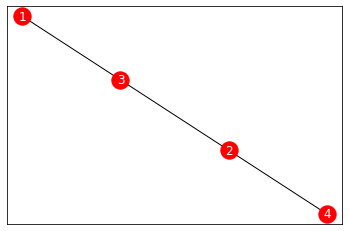

In [59]:
## Define the graph
G = nx.Graph()
G.add_edges_from([(1,3),(3,2),(2,4)])
pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, node_list=G.nodes(), pos=pos, node_color='r')
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, font_color='w', font_size=12)

def general_graph_partitioning(G, sampler=None, num_repeats=1000):
  Q = defaultdict(int)

  ## TODO: pass A and B as arguments and raise error when the 
  ##       condition is not satisfied
  A, B = 10, 1
  N = len(G.nodes())

  ## For Q_A
  for node in G.nodes():
    Q[(node, node)] += A * (1-N)

  for node_u in G.nodes():
    for node_v in G.nodes():
      Q[(node_u, node_v)] += 2 * A
     
  ## For Q_B
  for u,v in G.edges():
    Q[(u,u)] += B
    Q[(v,v)] += B
    Q[(u,v)] -= 2 * B

  return sampler.sample_qubo(Q, num_repeats=num_repeats)

print(general_graph_partitioning(G, sampler=QBSolv()))

In [54]:
QBSolv().sample_qubo??

Object `sample_qubo` not found.


{1: Text(0.25045051376785615, 0.8201392420124533, '1'),
 2: Text(0.5479614081969388, 0.6623561476589058, '2'),
 3: Text(0.17592324823704683, 0.32157934672129374, '3'),
 4: Text(0.062312206144534484, -0.1994255592379353, '4'),
 5: Text(-0.19803374701083132, -0.059419325939593495, '5'),
 6: Text(-0.2946132945795077, -0.5452298512151229, '6'),
 7: Text(-0.5440003347560374, -1.0, '7')}

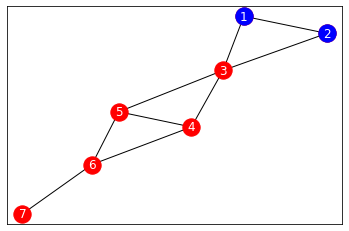

In [35]:
G = nx.Graph()
G.add_edges_from([(1, 2), (1, 3), (2, 3), (3, 4), (3, 5), (4, 5), (4, 6), (5, 6), (6, 7)])
pos = nx.spring_layout(G)

S = G.subgraph([1,2])
nx.draw_networkx_nodes(S, nodelist=S.nodes(), pos=pos, node_color='b')
nx.draw_networkx_labels(G, pos, font_color='w', font_size=12)

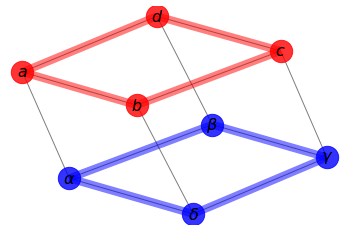

In [28]:
import matplotlib.pyplot as plt

import networkx as nx

G=nx.cubical_graph()
pos=nx.spring_layout(G) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G,pos,
                       nodelist=[0,1,2,3],
                       node_color='r',
                       node_size=500,
                   alpha=0.8)
nx.draw_networkx_nodes(G,pos,
                       nodelist=[4,5,6,7],
                       node_color='b',
                       node_size=500,
                   alpha=0.8)

# edges
nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)
nx.draw_networkx_edges(G,pos,
                       edgelist=[(0,1),(1,2),(2,3),(3,0)],
                       width=8,alpha=0.5,edge_color='r')
nx.draw_networkx_edges(G,pos,
                       edgelist=[(4,5),(5,6),(6,7),(7,4)],
                       width=8,alpha=0.5,edge_color='b')


# some math labels
labels={}
labels[0]=r'$a$'
labels[1]=r'$b$'
labels[2]=r'$c$'
labels[3]=r'$d$'
labels[4]=r'$\alpha$'
labels[5]=r'$\beta$'
labels[6]=r'$\gamma$'
labels[7]=r'$\delta$'
nx.draw_networkx_labels(G,pos,labels,font_size=16)

plt.axis('off')
#plt.savefig("labels_and_colors.png") # save as png
plt.show() # display

## References

[1] Lucas, Andrew. "Ising formulations of many NP problems." Frontiers in Physics 2 (2014): 5.
